In [15]:
!labelme

### Limitació de la memòria GPU i introducció de les dades a la pipeline de TF

##### Les pipelines de TensorFlow són com una línia de muntatge per a les dades. Imagina que tens un conjunt de peces de joguina que vols muntar en un cotxe. En lloc de fer-ho tot tu mateix, pots crear una línia de muntatge on cada persona fa una petita part del treball. Una persona posa les rodes, una altra posa el motor, una altra posa la carrosseria i així successivament fins que el cotxe està complet. Les pipelines de TensorFlow fan el mateix amb les dades. Les dades passen per diferents etapes on es transformen i es preparen per a l’ús en models d’aprenentatge automàtic. Això ajuda a fer el procés més ràpid i eficient.

In [1]:
#importació de llibreries necessàries
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt

In [106]:
#limitació de la memòria GPU (buscar doc!!!)
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [29]:
#carregar imatges dins de la pipeline
imatges = tf.data.Dataset.list_files('data\\images\\*.png') # l'asterisc fa buscar tots els arxius que són png

InvalidArgumentError: Expected 'tf.Tensor(False, shape=(), dtype=bool)' to be true. Summarized data: b'No files matched pattern: data\\images\\*.png'

In [32]:
#funció carregar imatge
def carregar_imatge(imatge): 
    byte_img = tf.io.read_file(imatge)
    img = tf.io.decode_png(byte_img)
    return img

In [33]:
imatges = imatges.map(carregar_imatge)

NameError: name 'imatges' is not defined

In [30]:
imatges.as_numpy_iterator().next()

NameError: name 'imatges' is not defined

In [10]:
type(imatges) #si surt "tensorflow.python.data.ops.map_op._MapDataset", les imatges s'han inclòs correctament

tensorflow.python.data.ops.map_op._MapDataset

### Divisió de dades per entrenar i validar

In [2]:
import os

In [17]:
def quantImatgesDividir(dir_carpeta):
    num_elements = len(os.listdir(dir_carpeta))
    n_entrenar = round(num_elements*0.7)
    n_provar = round(num_elements*0.15)
    n_validar = num_elements - (n_entrenar + n_provar)
    print(f"Has de posar {n_entrenar} a la carpeta 'train', {n_provar} a la carpeta 'test' i {n_validar} a la carpeta 'val'")

In [18]:
quantImatgesDividir('T:\REP\deteccio_prova\data\images')

Has de posar 35 a la carpeta 'train', 8 a la carpeta 'test' i 7 a la carpeta 'val'


In [4]:
for carpeta in ['train','test','val']:
    for arxiu in os.listdir(os.path.join('data', carpeta, 'images')): #per cada arxiu en cada carpeta
        nom_arxiu = arxiu.split('.')[0]+'.json' #extreu el nom de l'arxiu
        dir_existent = os.path.join('data','labels', nom_arxiu)#crea possible direcció
        if os.path.exists(dir_existent): #si la possible direcció existeix, desplaça l'arxiu .json corresponent
            nova_dir = os.path.join('data',carpeta,'labels',nom_arxiu)
            os.replace(dir_existent, nova_dir)#canviem

## Augment de les dades amb la llibreria Albumentations
##### Per augmentar les caixes delimitadores amb Albumentations, primer cal importar les llibreries necessàries i definir una canalització d’augmentació. A continuació, es defineixen els paràmetres de les caixes delimitadores i s’aplica l’augmentació a les imatges d’entrada. Finalment, es visualitzen les imatges augmentades i les caixes delimitadores corresponents.
##### Una canalització d’augmentació és una sèrie d’operacions d’augmentació que s’apliquen a les imatges d’entrada per obtenir imatges augmentades. Aquestes operacions poden incloure rotacions, escalatats, desplaçaments i altres transformacions geomètriques que s’apliquen a les imatges d’entrada per crear noves imatges que s’utilitzen per entrenar models de detecció d’objectes.


In [3]:
import albumentations as alb
import cv2

In [4]:
#pipeline, el que modifica les imatges
augmentor = alb.Compose([alb.RandomCrop(width=1024, height=1024),
                         alb.HorizontalFlip(p=0.5), 
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2), 
                         alb.RGBShift(p=0.2), 
                         alb.VerticalFlip(p=0.5)], 
                       bbox_params=alb.BboxParams(format='albumentations', #format de coords que volem (buscar docs)
                                                  label_fields=['class_labels']))

In [5]:
imatge = cv2.imread(os.path.join('data','train', 'images','10.png')) #obrim imatge

In [6]:
with open(os.path.join('data', 'train', 'labels', '10.json'), 'r') as f: #obrim json corresponent
    label = json.load(f)

In [7]:
#extreiem les coordenades
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [8]:
#les dividim per a què quadrin amb el model "albumentations" que hem escollit
coords = list(np.divide(coords, [1024,1024,1024,1024]))
#funciona d'una manera proporcional, és a dir, divideix 

In [9]:
coords

[0.5154622395833333,
 0.5724283854166666,
 0.7498372395833333,
 0.8068033854166666]

In [10]:
#aplicar augmentations
augmented = augmentor(image=imatge, bboxes=[coords], class_labels=['Maduixa'])

In [11]:
augmented['bboxes'][0][2:]

(0.7498372395833333, 0.42757161458333337)

In [12]:
augmented['bboxes']


[(0.5154622395833333,
  0.19319661458333337,
  0.7498372395833333,
  0.42757161458333337)]

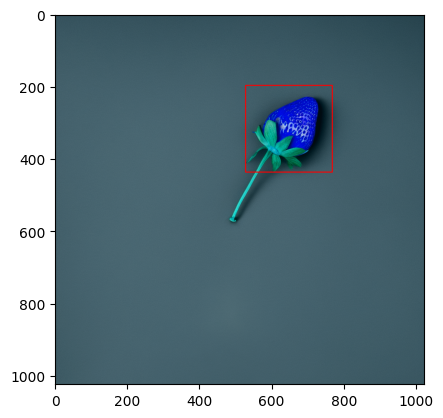

In [13]:
cv2.rectangle(augmented['image'], 
              tuple(np.multiply(augmented['bboxes'][0][:2], [1024,1024]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [1024,1024]).astype(int)), 
                    (255,0,0), 2)

plt.imshow(augmented['image'])

### Pipeline sencera

In [16]:
for partition in ['train','test','val']: 
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [1024,1024,1024,1024]))
            # ^^^ carregar imatges i json ^^^

        try: 
            for x in range(60):# quantitat d'imatges que surten d'una imatge base
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['Maduixa'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'),augmented['image'])
                
                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 
                    '''
                     La variable “annotation” és un diccionari que conté informació sobre la imatge i 
                     la seva anotació. Si el fitxer d’anotació existeix, el codi afegeix la caixa delimitadora
                     i la classe corresponent a l’objecte detectat a l’estructura “annotation”. 
                     Si el fitxer d’anotació no existeix, el codi assigna una caixa delimitadora i 
                     una classe buida a l’estructura “annotation”.
                    '''
                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

x_max is less than or equal to x_min for bbox [0.6603190104166667, 0.7547200520833334, 0.4471028645833333, 0.5105794270833334, 'Maduixa'].
x_max is less than or equal to x_min for bbox [0.73193359375, 0.30712890625, 0.53173828125, 0.07438151041666664, 'Maduixa'].
x_max is less than or equal to x_min for bbox [0.9793294270833333, 0.8214518229166666, 0.53662109375, 0.38199869791666663, 'Maduixa'].
x_max is less than or equal to x_min for bbox [0.7644856770833333, 0.83935546875, 0.3006184895833333, 0.20458984375, 'Maduixa'].
x_max is less than or equal to x_min for bbox [0.20133463541666669, 0.19156901041666666, 0.012532552083333315, 0.43570963541666663, 'Maduixa'].
x_max is less than or equal to x_min for bbox [0.48779296875000006, 0.80517578125, 0.25830078125, 0.4080403645833333, 'Maduixa'].
